In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.ascii
import scipy
%matplotlib inline

## Radial velocity data for GJ 436 b  
The parameters used below (period (days), time at periastron (days), eccentricity, argument of periastron (deg) and RV semi-amplitude (m/s) are taken from EXOFAST from the Chi-squared fit of the file also used below.

In [2]:
rv_data = astropy.io.ascii.read("UID_0057087_RVC_003.tbl.txt")

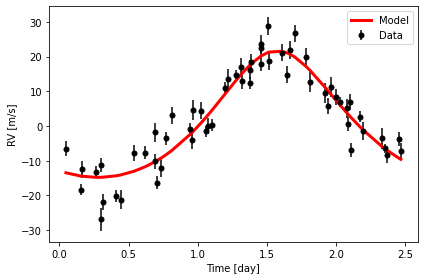

In [3]:
t = rv_data["JD"].data
if False:
    import JW_lib
    orbital_solution = [2.643939, 2453045.509344, 0.189799, 355.229197, 18.238337]
    rv = JW_lib.RadialVelocity(orbital_solution)
    # The parameters are period (P(days)), time at periastron (Tp (days)), eccentricity (e),
    # argument of periastron (ω (deg)), RV semi-amplitude (K (m/s))

    # Calculate model RVs
    rvs = rv.rv_drive(t)
else:
    import radvel
    orbital_solution = [2.643939, 2453045.509344, 0.189799, 355.229197 / 360.0 * 2 * np.pi, 18.238337]
    rvs = radvel.kepler.rv_drive(t, orbital_solution, use_c_kepler_solver=False)

per = 2.643939

%matplotlib inline
# Fold data and plot model against data
ind = np.argsort(t % per)
plt.errorbar(rv_data["JD"] % per, rv_data["Radial_Velocity"], rv_data["Radial_Velocity_Uncertainty"], 
             color="black", ms=5, marker="o", ls="none", label="Data")
plt.plot((t % per)[ind], rvs[ind], "r-", label="Model", lw=3)
plt.legend()
plt.xlabel("Time [day]")
plt.ylabel("RV [m/s]")
plt.tight_layout()
plt.savefig("RV_curve.png")

## Confirming the periodicity found with EXOFAST

In [4]:
import scipy.signal as signal
x = rv_data["JD"]
y = rv_data["Radial_Velocity"]
e = rv_data["Radial_Velocity_Uncertainty"]

In [5]:
nout = 1e5
f = np.linspace(0.01, 10.0, int(nout)) # frequency (1/day) at which power is calculated. 
#pgram = signal.lombscargle(x, y, f, normalize=True)
pgram = signal.lombscargle(x, y, f)

Text(0, 0.5, 'Power')

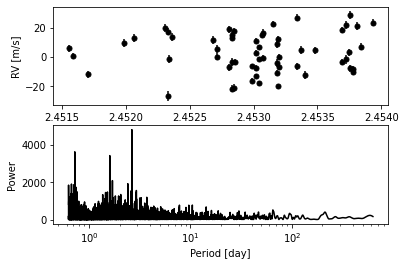

In [6]:
plt.subplot(2, 1, 1)
plt.errorbar(x, y , e, ms=5, marker="o", ls="none", color="black")
plt.xlabel("Time [BJD]")
plt.ylabel("RV [m/s]")
plt.subplot(2, 1, 2)
plt.plot(2 * np.pi / f, pgram, color="black")
plt.xscale("log")
plt.xlabel("Period [day]")
plt.ylabel("Power")

In [7]:
print("The period with the highest power is: ", 2 * np.pi / f[np.where(pgram == np.max(pgram))][0], " day")

The period with the highest power is:  2.6439321027765184  day


This result matches the value for the period found with EXOFAST (2.643939 days).

## Calculate the mass  
The different variations from K also come from EXOFAST by plotting the graph with the maximum and minimum passible amplitude of the data points. 

## 1) With the equation from the previous project
## $m_p = K \cdot m_\ast \cdot \sqrt{\frac{a}{Gm_\ast}}$  
$K$ = 18.24 m/s  
$m_\ast$ = 0.44 solar masses  
$G$ = 6.6743 × 10-11 m3 kg-1 s-2  
$a$ = 	0.0285 au

In [8]:
#The constants from above but converted to Si units
Km = 18.24
mstar = 0.44*1.989e+30
a = 0.0285*1.496e+11
G = 6.6743e-11

rv_mass = Km*(mstar)*np.sqrt((a)/(G*mstar))
print(rv_mass*1.67443e-25, 'Earth masses.') #mass of planet converted to Earth masses

22.83604684307412 Earth masses.


In [9]:
Ku = 20.94

rv_mass_up = Ku*(mstar)*np.sqrt((a)/(G*mstar))
print(rv_mass_up*1.67443e-25, 'Earth masses.')

26.21638272445023 Earth masses.


In [10]:
Kl = 15.54

rv_mass_low = Kl*(mstar)*np.sqrt((a)/(G*mstar))
print(rv_mass_low*1.67443e-25, 'Earth masses.')

19.455710961698017 Earth masses.


Range: 22.84 ± 3.38 Earth masses

## 2) With radvel

In [11]:
# Parameters: semi-amplitude RV (m/s), period (days),
# mass of star (solar units), eccentricity
Km = 18.24
P = 2.64385
Mstar = 0.44
e = 0.189799

In [12]:
# Calculating mass of planet assuming inclination angle is 90 degree
Planetmass = radvel.utils.Msini(Km, P, Mstar, e, Msini_units='earth')
print(Planetmass)

22.401661001550462


In [13]:
Ku = 20.94
Planetmass_up = radvel.utils.Msini(Ku, P, Mstar, e, Msini_units='earth')
print(Planetmass_up)

25.717696347174716


In [14]:
Kl = 15.54
Planetmass_low = radvel.utils.Msini(Kl, P, Mstar, e, Msini_units='earth')
print(Planetmass_low)

19.08562565592622


Range: 22.4 ± 3.3 Earth masses